# Developing Bayes Model on Apache Spark

In [40]:
import pandas as pd
import json
from sqlalchemy import create_engine

from pyspark.sql import SparkSession

import numpy as np
import seaborn as sns

In [1]:
import pandas as pd
import json
from sqlalchemy import create_engine

from pyspark.sql import SparkSession

# create SparkSession
# in config, add "spark.driver.extraClassPath" to specify additional jar postgresql-42.7.1.jar
# specify the driver path for jar_driver_path variable

jar_driver_path = "/Users/taufiqurrohman/Documents/ds_deploy_gcp/03_pyspark/cache/postgresql-42.7.1.jar"

spark = SparkSession \
    .builder \
    .config("spark.driver.extraClassPath", jar_driver_path) \
    .appName("Bayes classification using Spark") \
    .getOrCreate()

with open('cache/pass_conn_postgres.json') as json_file:
    postgres_prof = json.load(json_file)

conn_params = {
    'host': '127.0.0.1',                    # local host
    'database': 'learn_ds_deploy_gcp',      # database name, we want to save it to learn_ds_deploy_gcp
    'user': postgres_prof['user'],          # user
    'password': postgres_prof['password']   # password
}

table_name_flights = 'ex3_raw_flights_to2023'
table_name_traindays = 'ex3_trainday'

jdbc_url = f"jdbc:postgresql://localhost:5432/{conn_params['database']}"

# load flights data and traindays (training records) from postgresql database
# and create a temporary view so we can employ SQL on the dataframe

flights = spark.read \
    .format("jdbc") \
    .option("driver", "org.postgresql.Driver") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_flights) \
    .option("user", postgres_prof['user']) \
    .option("password", postgres_prof['password']) \
    .load()

flights.createOrReplaceTempView('flights')

traindays = spark.read \
    .format("jdbc") \
    .option("driver", "org.postgresql.Driver")  \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_traindays) \
    .option("user", postgres_prof['user']) \
    .option("password", postgres_prof['password']) \
    .load()

traindays.createOrReplaceTempView('traindays')

24/01/09 09:32:35 WARN Utils: Your hostname, Taufiqurs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.100.33 instead (on interface en0)
24/01/09 09:32:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/09 09:32:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Q1: Show records with delay > -20 and distance < 2000

Employing Spark SQL to do queries on the temporary view.

In [2]:
query = '''
    SELECT
        *
    FROM
        flights
    WHERE
        dep_delay > -20 AND distance < 2000
    LIMIT
        5
'''

result = spark.sql(query)
result.show()

+-------------------+--------------+---------------------+------+-------------------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+--------+
|            FL_DATE|UNIQUE_CARRIER|ORIGIN_AIRPORT_SEQ_ID|ORIGIN|DEST_AIRPORT_SEQ_ID|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|DISTANCE|
+-------------------+--------------+---------------------+------+-------------------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+--------+
|2023-01-02 00:00:00|            9E|              1052907|   BDL|            1295304| LGA|        0800|    0757|     -3.0|    11.0|      0808|     0833|   20.0|        0905|    0853|    -12.0|      0.0|     0.0|   101.0|
|2023-01-03 00:00:00|            9E|              1052907|   BDL|            1295304| LGA|        0800|    0755|    

### Q2: Check the traindays dataframe

In [3]:
query = '''
    SELECT
        *
    FROM
        traindays
    LIMIT
        5
'''

result = spark.sql(query)
result.show()

+-------------------+------------+
|            FL_DATE|is_train_day|
+-------------------+------------+
|2023-01-01 00:00:00|       False|
|2023-01-02 00:00:00|        True|
|2023-01-03 00:00:00|        True|
|2023-01-04 00:00:00|       False|
|2023-01-05 00:00:00|        True|
+-------------------+------------+



### Q3: Make the flights dataframe only contain data for training (traindays)

In [27]:
query = '''
    SELECT
        f.FL_DATE AS date,
        f.DISTANCE AS distance,
        f.DEP_DELAY AS dep_delay,
        f.ARR_DELAY AS arr_delay,
        IF(f.ARR_DELAY < 15, 1, 0) AS ontime
    FROM
        flights AS f
    JOIN
        traindays AS t
    ON
        f.FL_DATE == t.FL_DATE
    WHERE
        t.is_train_day == TRUE AND f.DEP_DELAY IS NOT NULL
    ORDER BY
        f.DEP_DELAY DESC
'''

# execut the query
# and save it as a spark dataframe

flights = spark.sql(query)     

In [36]:
display(flights.head(5))
print(flights.count())

[Row(date=datetime.datetime(2023, 1, 24, 0, 0), distance=507.0, dep_delay=3024.0, arr_delay=3063.0, ontime=0),
 Row(date=datetime.datetime(2023, 1, 26, 0, 0), distance=328.0, dep_delay=2669.0, arr_delay=2687.0, ontime=0),
 Row(date=datetime.datetime(2023, 1, 3, 0, 0), distance=2454.0, dep_delay=2554.0, arr_delay=2557.0, ontime=0),
 Row(date=datetime.datetime(2023, 1, 27, 0, 0), distance=1231.0, dep_delay=2168.0, arr_delay=None, ontime=0),
 Row(date=datetime.datetime(2023, 1, 21, 0, 0), distance=1744.0, dep_delay=2130.0, arr_delay=2078.0, ontime=0)]

373021


## Start the Analysis & Creating the Model

In [34]:
# filtering the data first for a cleaner analysis

df = flights[(flights['distance'] < 2000) &
             (flights['dep_delay'] > -20) &
             (flights['dep_delay'] < 30)]

df.count()  # check the length of spark dataframe

306322

### Make a jointplot to know the correlation between distance and departure delay

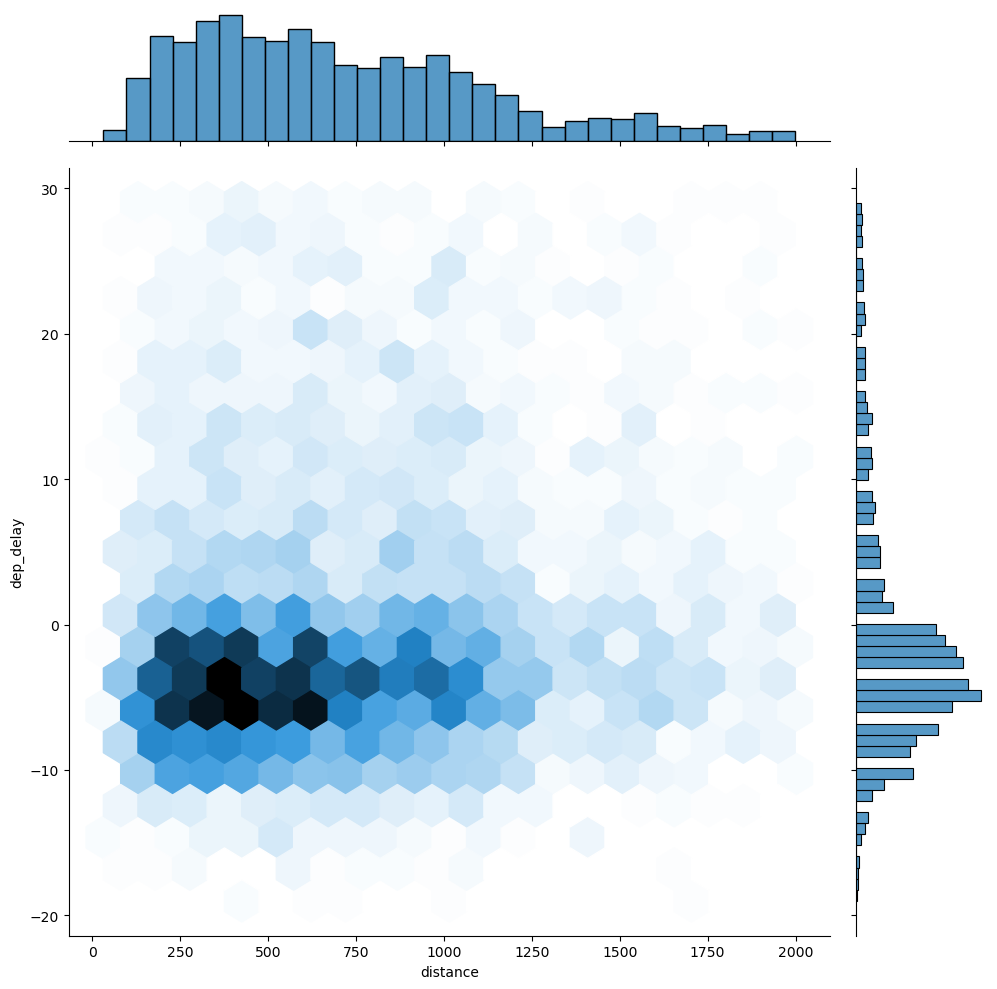

In [38]:
import seaborn as sns

pdf = df.sample(False, 0.02, 20).toPandas()                             # create a df, as spark df cannot be visualized, using toPandas() method
g = sns.jointplot(x=pdf['distance'], y=pdf['dep_delay'], kind='hex',    # build a jointplot based on the df
                  height=10, joint_kws={'gridsize':20})

### Create bins for the model using bayesian

In [46]:
# the approxQuantile method is useful for calculating quantiles for spark df

distthresh = flights.approxQuantile('distance',                      # params 1: column to make the quantiles
                                    list(np.arange(0, 1.0, 0.2)),    # params 2: create quantiles for 0.2, 0.4, 0.6, 0.8
                                    0.02                             # params 3: relative error, which controls the accuracy of the approximation
                                    )

delaythresh = flights.approxQuantile('dep_delay',
                                     list(np.arange(0, 1.0, 0.2)),
                                     0.02
                                     )

print('bins threshold for distance:', distthresh)
print('bins threshold for dep_delay:', delaythresh)

bins threshold for distance: [31.0, 358.0, 569.0, 859.0, 1182.0]
bins threshold for dep_delay: [-52.0, -7.0, -4.0, 0.0, 11.0]


In [53]:
import pyspark.sql.functions as F   # import functions, allowing to use spark's built-in functions in the code.

delaythresh = range(10, 20)

df = pd.DataFrame(columns=['dist_thresh', 'delay_thresh', 'frac_ontime'])

for m in range(0, len(distthresh) - 1):
    for n in range(0, len(delaythresh) - 1):
        bdf = flights[(flights['distance'] >= distthresh[m])
             & (flights['distance'] < distthresh[m+1])
             & (flights['dep_delay'] >= delaythresh[n])
             & (flights['dep_delay'] < delaythresh[n+1])]
        
        '''
        use sum to calculate number of ontime flights
        use count to calculate all flights in the data
        then divide the two numbers to get the ontime fraction
        use "collect" method to get all the numbers from spark distributed to the local machine
        see the reference below on what it would look like
        '''
        
        ontime_frac = bdf.agg(F.sum('ontime')).collect()[0][0] / bdf.agg(F.count('ontime')).collect()[0][0]
        print (m, n, ontime_frac)

        # append the result to a dataframe

        df = df.append({
            'dist_thresh': distthresh[m], 
            'delay_thresh': delaythresh[n],
            'frac_ontime': ontime_frac
        }, ignore_index=True)

0 0 0.804185351270553


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


0 1 0.785958904109589


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


0 2 0.7964774951076321


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


0 3 0.6991701244813278


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


0 4 0.7168316831683168


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


0 5 0.6554809843400448


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


0 6 0.6211031175059952


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


0 7 0.6425233644859814


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


0 8 0.5609756097560976


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


1 0 0.7826825127334465


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


1 1 0.7948717948717948


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


1 2 0.798804780876494


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


1 3 0.7505330490405118


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


1 4 0.7512315270935961


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


1 5 0.7437810945273632


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


1 6 0.6421052631578947


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


1 7 0.6314363143631436


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


1 8 0.5626911314984709


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


2 0 0.8244897959183674


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


2 1 0.7893982808022922


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


2 2 0.7984


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


2 3 0.7598627787307033


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


2 4 0.6939890710382514


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


2 5 0.7168316831683168


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


2 6 0.6941649899396378


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


2 7 0.6599099099099099


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


2 8 0.6109839816933639


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


3 0 0.7864214992927864


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


3 1 0.7923728813559322


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


3 2 0.7844408427876823


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


3 3 0.745


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


3 4 0.7291311754684838


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


3 5 0.7145359019264448


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


3 6 0.6996047430830039


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


3 7 0.6423529411764706


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


3 8 0.620137299771167


/var/folders/vm/yq09zwnn4552bd960_dwt5840000gn/T/ipykernel_40558/4016808302.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


In [62]:
print('sum function:', bdf.agg(F.sum('ontime')).collect()[0][0])
print('count function:', bdf.agg(F.count('ontime')).collect()[0][0])

sum function: 271
count function: 437


In [54]:
df

,dist_thresh,delay_thresh,frac_ontime
0,31.0,10.0,0.804185
1,31.0,11.0,0.785959
2,31.0,12.0,0.796477
3,31.0,13.0,0.699170
4,31.0,14.0,0.716832
5,31.0,15.0,0.655481
6,31.0,16.0,0.621103
7,31.0,17.0,0.642523
8,31.0,18.0,0.560976
9,358.0,10.0,0.782683


### Create a score table to make a decision

If the departure delay is greater than the threshold corresponding to how far the flight is, then we will cancel the meeting because we expect that the flight will be delayed.

In [63]:
df['score'] = abs(df['frac_ontime'] - 0.7)
bayes = df.sort_values(['score']).groupby('dist_thresh').head(1).sort_values('dist_thresh')
bayes

,dist_thresh,delay_thresh,frac_ontime,score
3,31.0,13.0,0.699170,0.000830
14,358.0,15.0,0.743781,0.043781
24,569.0,16.0,0.694165,0.005835
33,859.0,16.0,0.699605,0.000395
